In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
#from skmultilearn.adapt import mlknn
#from skmultilearn.problem_transform import ClassifierChain
#from skmultilearn.problem_transform import BinaryRelevance
#from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [2]:
#Creating db file from csv

if not os.path.isfile('econ_train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///econ_train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('econbiz.csv', names=['Id', 'title', 'labels', 'fold'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

180000 rows
360000 rows
540000 rows
720000 rows
900000 rows
1080000 rows
Time taken to run this cell : 0:00:22.981397


In [3]:
if os.path.isfile('econ_train.db'):
    start = datetime.now()
    con = sqlite3.connect('econ_train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    #Always remember to close the database
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("run the above cell to genarate econ_train.db file")

Number of rows in the database : 
 1064635
Time taken to count the number of rows : 0:00:00.376885


In [4]:

if os.path.isfile('econ_train.db'):
    start = datetime.now()
    con = sqlite3.connect('econ_train.db')
    df_no_dup = pd.read_sql_query('SELECT title, labels, COUNT(*) as cnt_dup FROM data GROUP BY title, labels', con) #non duplicate df
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

Time taken to run this cell : 0:00:07.553796


In [6]:
len(df_no_dup[df_no_dup.cnt_dup > 1]) # to check duplicate data in our df

0

In [7]:
df_no_dup.shape # to check number of data points and columns

(1064635, 3)

</h3> We have total of 10,64,635 data points with 3 columns in our data </h3>

In [10]:
df_no_dup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1064635 entries, 0 to 1064634
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   title    1064635 non-null  object
 1   labels   1064635 non-null  object
 2   cnt_dup  1064635 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 24.4+ MB


In [11]:
start = datetime.now()
df_no_dup["label_count"] = df_no_dup["labels"].apply(lambda text: len(text.split("\t"))) # to get label count for each data point
# adding a new feature number of labels per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:00.823767


,title,labels,cnt_dup,label_count
0,"!Why unions matter"" : an orientation for Orego...",11313-3\t19503-0\t18123-1\t16629-0\t17829-1,1,5
1,""" I know what You want to know"": the impact of...",12571-4\t15722-1,1,2
2,""" Perestroyka"" and Soviet agriculture",12945-3\t18980-6\t10994-0\t17461-0,1,4
3,"""(Ma)Lingering on the disabled list""",13363-6\t16670-3\t29904-4\t16131-5\t17829-1,1,5
4,"""... And six hundred thousand men were dead.""",16267-1\t15698-0\t10975-4\t15690-2\t17829-1,1,5


In [12]:
# distribution of number of labels per title
df_no_dup.label_count.value_counts()

4     237779
3     217644
5     195395
2     134790
6     125717
7      67189
8      31644
1      26746
9      14553
10      6167
11      2860
12      1528
13       922
14       565
15       381
16       211
17       159
18       147
19        71
20        42
21        38
22        23
23        18
24        12
25        10
26         9
27         5
29         3
28         1
30         1
33         1
34         1
36         1
40         1
43         1
Name: label_count, dtype: int64

<h3>It can be observed from the above result that most of the data points have 3,4 or 5 labels. </h3>

In [13]:
#by default 'split()' will tokenize each tag using tab.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split('\t'))
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
label_data = vectorizer.fit_transform(df_no_dup['labels'])

In [14]:
print("Number of data points :", label_data.shape[0])
print("Number of unique labels :", label_data.shape[1])

Number of data points : 1064635
Number of unique labels : 5662


In [15]:
#'get_feature_name()' gives us the vocabulary.
labels = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the labels we have :", labels[:10])

Some of the labels we have : ['10000-1', '10001-6', '10002-4', '10005-5', '10006-3', '10007-1', '10008-6', '10010-5', '10011-3', '10012-1']


In [16]:
#Number of times a label appeared
freqs = label_data.sum(axis=0).A1 # https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
result = dict(zip(labels, freqs))

In [17]:
#Saving this dictionary to csv files.
if not os.path.isfile('labels_counts_dict_data.csv'):
    with open('labels_counts_dict_data.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
labels_df = pd.read_csv("labels_counts_dict_data.csv", names=['labels', 'counts'])
labels_df.head()

,labels,counts
0,10000-1,383
1,10001-6,735
2,10002-4,106
3,10005-5,429
4,10006-3,2746


In [18]:
#sorting label in descending order based on their frequency in data point and saving it to df
labels_df_sorted = labels_df.sort_values(['counts'], ascending=False)
labels_counts = labels_df_sorted['counts'].values

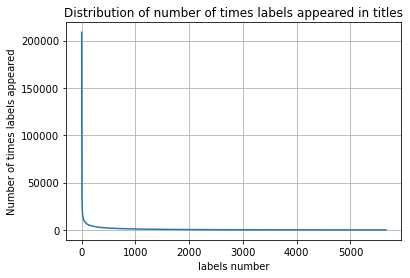

In [19]:
#For seeing the distribution of label
plt.plot(labels_counts)
plt.title("Distribution of number of times labels appeared in titles")
plt.grid()
plt.xlabel("labels number")
plt.ylabel("Number of times labels appeared")
plt.show()

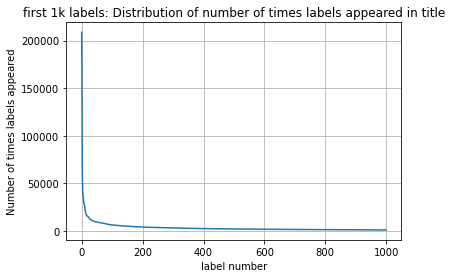

40 [208748  13018   9342   7620   6183   5449   4868   4334   4023   3732
   3407   3171   2976   2814   2653   2525   2400   2286   2218   2134
   1983   1889   1822   1756   1691   1618   1543   1498   1455   1406
   1354   1315   1264   1215   1168   1140   1114   1078   1047   1015]


In [20]:
plt.plot(labels_counts[0:1000])
plt.title('first 1k labels: Distribution of number of times labels appeared in title')
plt.grid()
plt.xlabel("label number")
plt.ylabel("Number of times labels appeared")
plt.show()
print(len(labels_counts[0:1000:25]), labels_counts[0:1000:25])

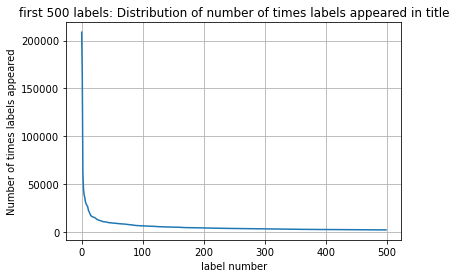

34 [208748  16884  11734   9577   8515   7620   6540   6078   5720   5163
   4868   4547   4286   4100   3899   3732   3551   3351   3238   3095
   2976   2883   2787   2713   2601   2525   2434   2378   2311   2251
   2218   2164   2126   2002]


In [21]:
plt.plot(labels_counts[0:500])
plt.title('first 500 labels: Distribution of number of times labels appeared in title')
plt.grid()
plt.xlabel("label number")
plt.ylabel("Number of times labels appeared")
plt.show()
print(len(labels_counts[0:500:15]), labels_counts[0:500:15])

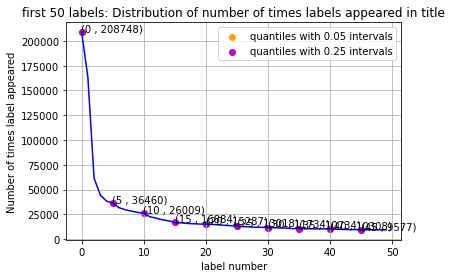

10 [208748  36460  26009  16884  15287  13018  11734  10734  10308   9577]


In [22]:
plt.plot(labels_counts[0:50], c='b')
plt.scatter(x=list(range(0,50,5)), y=labels_counts[0:50:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,50,5)), y=labels_counts[0:50:5], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,50,5)), labels_counts[0:50:5]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 50 labels: Distribution of number of times labels appeared in title')
plt.grid()
plt.xlabel("label number")
plt.ylabel("Number of times label appeared")
plt.legend()
plt.show()
print(len(labels_counts[0:50:5]), labels_counts[0:50:5])

In [23]:
# Store labels greater than 10K in one list
lst_labels_gt_10k = labels_df[labels_df.counts>10000].labels
#Print the length of the list
print ('{} labels are used more than 10000 times'.format(len(lst_labels_gt_10k)))
# Store labels greater than 100K in one list
lst_labels_gt_50k = labels_df[labels_df.counts>50000].labels
#Print the length of the list.
print ('{} labels are used more than 50000 times'.format(len(lst_labels_gt_50k)))

42 labels are used more than 10000 times
3 labels are used more than 50000 times


In [24]:
#Labels per title
#Storing the count of labels in each labels in list 'labels_count'
labels_title_count = label_data.sum(axis=1).tolist()
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
labels_title_count=[int(j) for i in labels_title_count for j in i]
print ('We have total {} datapoints.'.format(len(labels_title_count)))

print(labels_title_count[:5])

We have total 1064635 datapoints.
[5, 2, 4, 5, 5]


In [25]:
print( "Maximum number of labels per title: %d"%max(labels_title_count))
print( "Minimum number of labels per title: %d"%min(labels_title_count))
print( "Avg. number of labels per title: %f"% ((sum(labels_title_count)*1.0)/len(labels_title_count)))

Maximum number of labels per title: 43
Minimum number of labels per title: 1
Avg. number of labels per title: 4.355530


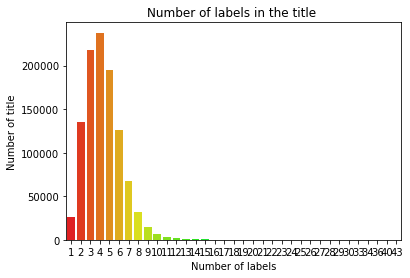

In [26]:
sns.countplot(labels_title_count, palette='gist_rainbow')
plt.title("Number of labels in the title ")
plt.xlabel("Number of labels")
plt.ylabel("Number of title")
plt.show()

<b>Observations:</b><br />
1. Maximum number of labels per title: 43
2. Minimum number of labels per title: 1
3. Avg. number of labels per title: 4.35
4. Most of the labels are having 3, 4 or 5 labels

<h3> Cleaning and pre-processing of title</h3>

In [28]:
#Checking the current state of original dataframe
df_no_dup.head(2)

,title,labels,cnt_dup,label_count
0,"!Why unions matter"" : an orientation for Orego...",11313-3\t19503-0\t18123-1\t16629-0\t17829-1,1,5
1,""" I know what You want to know"": the impact of...",12571-4\t15722-1,1,2


In [29]:
# We we create new df called df_econbiz with only title and labels from orifginal df
df_econbiz = df_no_dup.drop(['cnt_dup', 'label_count'], axis=1)

In [30]:
df_econbiz.head(2)

,title,labels
0,"!Why unions matter"" : an orientation for Orego...",11313-3\t19503-0\t18123-1\t16629-0\t17829-1
1,""" I know what You want to know"": the impact of...",12571-4\t15722-1


In [31]:
df_econbiz.title.iloc[56] #checking the sample title

'"A study on the development of China\'s laser & optoelectronic technology and industry" : with city cases of Wuhan, Shanghai and Changchun'

<h3> From the above sample title result we can see that the title conatain special character, tabs and unneccesary words</h3>
<h3> We need to process this textual data before feeding it to the clasifier </h3>

<h2> Data Preprocessing </h2>

In [32]:
stop_wrds = set(stopwords.words('english'))
snoball_stemmer = SnowballStemmer("english")

In [36]:
#https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def removePunctuation(text):
    cleanedText = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    cleanedText = re.sub(r'\s+[a-zA-Z]\s+', ' ', cleanedText)
    cleanedText = re.sub(r'\s+', ' ', cleanedText, flags=re.I)
    cleanedText = re.sub(r'[^A-Za-z]+',' ',text)
    cleanedText = re.sub(r'[?|!|\'|"|#|+|@|)|(]', r' ', cleanedText) # Removes special characters like  @, ?, ! etc.,
    cleanedText = re.sub(r'[.|,|)|(|\|/]', r' ', cleanedText)
    cleanedText = re.sub(r'[*|&|=|$|%|+|@|)|(]', r' ', cleanedText) # Removes special characters like  @, ?, ! etc.,
    cleanedText = re.sub(r'[,|;|:|}|{|-|_|£]', r' ', cleanedText) # Removes special characters like  @, ?, ! etc.,
    cleanedText = cleanedText.lower()
    return cleanedText

In [37]:
def preProcessText(text_col):
    i=0
    strng = ' '
    
    final_text_corpus = []
    
    for text in text_col.values:
        filtered_sentence = []
        #text = removeHtmlTags(text)
        for word in text.split():
            for cleaned_words in removePunctuation(word).split():
                if ((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                    if (cleaned_words.lower() not in stop_wrds):
                        stemmed_words = (snoball_stemmer.stem(cleaned_words.lower())).encode('utf8')
                        words = stemmed_words.decode('utf8')
                        #lemm_words = lemmatizer.lemmatize(words)
                        filtered_sentence.append(words)
                    else:
                        continue
                else:
                    continue
        
        strng = " ".join(filtered_sentence)
        
        final_text_corpus.append(str(strng))
        i += 1
    
    return final_text_corpus

In [38]:
start = datetime.now()
cleaned_title = preProcessText(df_econbiz.title)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:05:30.416875


In [40]:
df_econbiz['clean_title'] = cleaned_title #assigning clean title as new column to existing df

In [41]:
df_econbiz_cleaned = df_econbiz.drop(['title'], axis=1)

In [42]:
df_econbiz_cleaned = df_econbiz_cleaned[['clean_title', 'labels']]

In [43]:
df_econbiz_cleaned.head(2)

,clean_title,labels
0,union matter orient oregon legisl candid thier...,11313-3\t19503-0\t18123-1\t16629-0\t17829-1
1,know want know impact interviewe abil identifi...,12571-4\t15722-1


In [44]:
df_econbiz_cleaned.isnull().sum()# to check any null values after vectorization

clean_title    0
labels         0
dtype: int64

In [45]:
for i in range(0,5):
    print('title after cleaning title')
    print('='*50)
    print(df_econbiz_cleaned.clean_title.iloc[i])
    print('-'*50)


title after cleaning title
union matter orient oregon legisl candid thier staff
--------------------------------------------------
title after cleaning title
know want know impact interviewe abil identifi criteria interview perform construct relat valid
--------------------------------------------------
title after cleaning title
perestroyka soviet agricultur
--------------------------------------------------
title after cleaning title
linger disabl list
--------------------------------------------------
title after cleaning title
six hundr thousand men dead
--------------------------------------------------


<h1> Machine Learning Multi Label classifier Models </h1>

<h2> Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [48]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split('\t'), binary='true')
multilabel_y = vectorizer.fit_transform(df_econbiz_cleaned['labels'])

In [49]:
def labels_to_choose(n):
    '''
    this function lets to choose top k labels from the existing totla labels
    '''
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_labels_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_labels_i[:n]]
    return multilabel_yn

def title_explained_fn(n):
    multilabel_yn = labels_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [50]:
title_explained = []
total_labels=multilabel_y.shape[1]
total_title=df_econbiz_cleaned.shape[0]
for i in range(500, total_labels, 100):
    title_explained.append(np.round(((total_title-title_explained_fn(i))/total_title)*100,3))

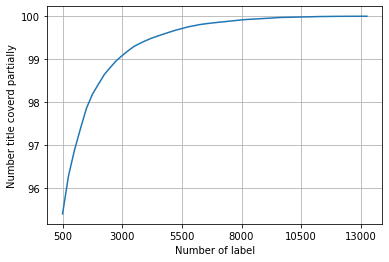

with  500 labels we are covering  95.391 % of questions


In [51]:
fig, ax = plt.subplots()
ax.plot(title_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of label")
plt.ylabel("Number title coverd partially")
plt.grid()
plt.show()
# you can choose any number of labels based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",500,"labels we are covering ",title_explained[0],"% of questions")

In [52]:
multilabel_yx = labels_to_choose(500)
print("number of title that are not covered :", title_explained_fn(500),"out of ", total_title)

number of title that are not covered : 49065 out of  1064635


In [53]:
print("Number of labels in sample :", multilabel_y.shape[1])
print("number of labels taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of labels in sample : 5662
number of labels taken : 500 ( 8.830801836806781 %)


__ We will consider top 8% labels which covers  95% of the title __

<h2> Split the data into train and test </h2>

In [54]:
# we will choose 80% of data as training and 20% as testing data
total_size=df_econbiz_cleaned.shape[0]
train_size=int(0.80*total_size)

x_train=df_econbiz_cleaned.head(train_size)
x_test=df_econbiz_cleaned.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [55]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (851708, 500)
Number of data points in test data : (212927, 500)


<h2>Featurization of data </h2>

In [56]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['clean_title'])
x_test_multilabel = vectorizer.transform(x_test['clean_title'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:47.857464


In [57]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (851708, 11143) Y : (851708, 500)
Dimensions of test data X: (212927, 11143) Y: (212927, 500)


In [62]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1) # linear regression
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro precision :",metrics.precision_score(y_test,predictions, average='macro'))
print("micro precision :",metrics.precision_score(y_test,predictions, average='micro'))
print("nDCG score :",metrics.ndcg_score(y_test.toarray(),predictions.toarray()))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

accuracy : 0.11201021946488703
macro precision : 0.6104030306321908
micro precision : 0.7290244762013491
macro f1 score : 0.3071228129161425
micro f1 scoore : 0.37636103188575143
hamming loss : 0.0045718391749284965
Precision recall report :
               precision    recall  f1-score   support

           0       0.67      0.30      0.42     36511
           1       0.82      0.25      0.39     38856
           2       0.55      0.08      0.15     13952
           3       0.76      0.39      0.52      9048
           4       0.91      0.23      0.36      9269
           5       0.33      0.00      0.01      7331
           6       0.93      0.60      0.73      4103
           7       0.94      0.77      0.85      5646
           8       0.64      0.23      0.34      5273
           9       0.87      0.44      0.59      5631
          10       0.78      0.36      0.49      5227
          11       0.96      0.64      0.77      4471
          12       0.95      0.46      0.62      4526


In [66]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l2'), n_jobs=-1) #svm models
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro precision :",metrics.precision_score(y_test,predictions, average='macro'))
print("micro precision :",metrics.precision_score(y_test,predictions, average='micro'))
print("nDCG score :",metrics.ndcg_score(y_test.toarray(),predictions.toarray()))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

accuracy : 0.11462144302977077
macro precision : 0.6287510487045239
micro precision : 0.8057288679223197
nDCG score : 0.4292672237074933
macro f1 score : 0.28901804532120584
micro f1 scoore : 0.367163777043129
hamming loss : 0.00445733044658498
Precision recall report :
               precision    recall  f1-score   support

           0       0.70      0.27      0.39     36511
           1       0.88      0.18      0.30     38856
           2       0.58      0.00      0.00     13952
           3       0.73      0.45      0.56      9048
           4       0.94      0.22      0.36      9269
           5       0.00      0.00      0.00      7331
           6       0.93      0.61      0.73      4103
           7       0.94      0.79      0.86      5646
           8       0.70      0.20      0.31      5273
           9       0.87      0.46      0.60      5631
          10       0.79      0.37      0.51      5227
          11       0.96      0.65      0.77      4471
          12       0.95  

In [69]:
# refeaturization with 50000 max features
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=50000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['clean_title'])
x_test_multilabel = vectorizer.transform(x_test['clean_title'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:46.497701


In [70]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (851708, 11143) Y : (851708, 500)
Dimensions of test data X: (212927, 11143) Y: (212927, 500)


In [71]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1) # linear regression
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro precision :",metrics.precision_score(y_test,predictions, average='macro'))
print("micro precision :",metrics.precision_score(y_test,predictions, average='micro'))
print("nDCG score :",metrics.ndcg_score(y_test.toarray(),predictions.toarray()))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

accuracy : 0.11189750477863306
macro precision : 0.6098118866097875
micro precision : 0.7287716323869862
nDCG score : 0.4423215955389203
macro f1 score : 0.30693531869403556
micro f1 scoore : 0.37659336830887774
hamming loss : 0.004571670102899115
Precision recall report :
               precision    recall  f1-score   support

           0       0.67      0.30      0.41     36511
           1       0.82      0.26      0.39     38856
           2       0.55      0.08      0.15     13952
           3       0.76      0.39      0.52      9048
           4       0.91      0.23      0.36      9269
           5       0.29      0.00      0.01      7331
           6       0.93      0.60      0.73      4103
           7       0.94      0.77      0.85      5646
           8       0.65      0.23      0.34      5273
           9       0.88      0.44      0.58      5631
          10       0.78      0.36      0.50      5227
          11       0.96      0.64      0.77      4471
          12       0.9

In [72]:
start = datetime.now()
classifier = OneVsRestClassifier(LogisticRegression(), n_jobs=-1) # linear regression
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro precision :",metrics.precision_score(y_test,predictions, average='macro'))
print("micro precision :",metrics.precision_score(y_test,predictions, average='micro'))
print("nDCG score :",metrics.ndcg_score(y_test.toarray(),predictions.toarray()))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

accuracy : 0.12283082934526857
macro precision : 0.6425596392280452
micro precision : 0.7347723546191685
nDCG score : 0.46766524074994076
macro f1 score : 0.33572463391806545
micro f1 scoore : 0.4080846487978065
hamming loss : 0.004456832623387358
Precision recall report :
               precision    recall  f1-score   support

           0       0.65      0.38      0.48     36511
           1       0.78      0.32      0.46     38856
           2       0.58      0.13      0.21     13952
           3       0.77      0.43      0.55      9048
           4       0.90      0.23      0.37      9269
           5       0.34      0.01      0.01      7331
           6       0.93      0.60      0.73      4103
           7       0.95      0.77      0.85      5646
           8       0.67      0.28      0.39      5273
           9       0.89      0.44      0.59      5631
          10       0.79      0.38      0.51      5227
          11       0.96      0.64      0.77      4471
          12       0.9

In [73]:
# refeaturization
start = datetime.now()
vectorizer = TfidfVectorizer(max_features=25000,  
                             tokenizer = lambda x: x.split())
x_train_multilabel = vectorizer.fit_transform(x_train['clean_title'])
x_test_multilabel = vectorizer.transform(x_test['clean_title'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:05.195748


In [74]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (851708, 25000) Y : (851708, 500)
Dimensions of test data X: (212927, 25000) Y: (212927, 500)


In [75]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1) # linear regression
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro precision :",metrics.precision_score(y_test,predictions, average='macro'))
print("micro precision :",metrics.precision_score(y_test,predictions, average='micro'))
print("nDCG score :",metrics.ndcg_score(y_test.toarray(),predictions.toarray()))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

accuracy : 0.10437379947118026
macro precision : 0.5847171329877867
micro precision : 0.7207966397360696
nDCG score : 0.42143217939419747
macro f1 score : 0.27772275504109095
micro f1 scoore : 0.3558171601019824
hamming loss : 0.004651566029672141
Precision recall report :
               precision    recall  f1-score   support

           0       0.66      0.30      0.41     36511
           1       0.79      0.24      0.37     38856
           2       0.56      0.08      0.14     13952
           3       0.75      0.38      0.51      9048
           4       0.89      0.22      0.35      9269
           5       0.31      0.00      0.01      7331
           6       0.93      0.60      0.73      4103
           7       0.94      0.77      0.85      5646
           8       0.65      0.21      0.32      5273
           9       0.87      0.44      0.58      5631
          10       0.76      0.28      0.41      5227
          11       0.96      0.65      0.77      4471
          12       0.9

In [76]:
start = datetime.now()
classifier = OneVsRestClassifier(svm.LinearSVC(), n_jobs=-1) # linear SVM
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro precision :",metrics.precision_score(y_test,predictions, average='macro'))
print("micro precision :",metrics.precision_score(y_test,predictions, average='micro'))
print("nDCG score :",metrics.ndcg_score(y_test.toarray(),predictions.toarray()))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

accuracy : 0.11506760532952608
macro precision : 0.6487163713230076
micro precision : 0.7685981328388438
nDCG score : 0.4415107336220627
macro f1 score : 0.2833647373646661
micro f1 scoore : 0.37545781330353906
hamming loss : 0.004494385399690974
Precision recall report :
               precision    recall  f1-score   support

           0       0.65      0.35      0.45     36511
           1       0.78      0.29      0.42     38856
           2       0.57      0.06      0.10     13952
           3       0.75      0.42      0.54      9048
           4       0.89      0.24      0.38      9269
           5       0.15      0.00      0.00      7331
           6       0.93      0.62      0.74      4103
           7       0.94      0.79      0.86      5646
           8       0.65      0.22      0.33      5273
           9       0.88      0.46      0.60      5631
          10       0.80      0.30      0.43      5227
          11       0.95      0.66      0.78      4471
          12       0.95

In [77]:
# refeaturization with 50000 max features
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=50000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['clean_title'])
x_test_multilabel = vectorizer.transform(x_test['clean_title'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:14.740150


In [ ]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

In [78]:
start = datetime.now()
classifier = OneVsRestClassifier(svm.LinearSVC(), n_jobs=-1) # linear SVM
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro precision :",metrics.precision_score(y_test,predictions, average='macro'))
print("micro precision :",metrics.precision_score(y_test,predictions, average='micro'))
print("nDCG score :",metrics.ndcg_score(y_test.toarray(),predictions.toarray()))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

accuracy : 0.12768225729945004
macro precision : 0.6825461779039803
micro precision : 0.7705451317740154
nDCG score : 0.470390116534586
macro f1 score : 0.34057270228305325
micro f1 scoore : 0.41274634396160925
hamming loss : 0.004362142894043498
Precision recall report :
               precision    recall  f1-score   support

           0       0.67      0.36      0.47     36511
           1       0.80      0.30      0.44     38856
           2       0.59      0.08      0.14     13952
           3       0.76      0.44      0.56      9048
           4       0.91      0.23      0.37      9269
           5       1.00      0.00      0.00      7331
           6       0.94      0.60      0.73      4103
           7       0.95      0.79      0.86      5646
           8       0.69      0.27      0.38      5273
           9       0.89      0.45      0.60      5631
          10       0.80      0.39      0.52      5227
          11       0.96      0.65      0.77      4471
          12       0.96

In [79]:
! pip install -U prettytable

<h1> Results </h1>
<h1> Best scores of both Logistice Regression and Linear SVC </h1>

In [1]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model Name", "micro averaged Precision score", "micro averaged F1 score", "nDCG score"]
x.add_row(["Linear SVM", 0.77, 0.412, 0.47])
x.add_row(["Logistic Regression", 0.73, 0.408, 0.467])


print(x)

+---------------------+--------------------------------+-------------------------+------------+
|      Model Name     | micro averaged Precision score | micro averaged F1 score | nDCG score |
+---------------------+--------------------------------+-------------------------+------------+
|      Linear SVM     |              0.77              |          0.412          |    0.47    |
| Logistic Regression |              0.73              |          0.408          |   0.467    |
+---------------------+--------------------------------+-------------------------+------------+
